# Checkpoint 3

Implement here your algorithm to estimate the parametric field from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- your estimates of parametric field


In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp3

Cloning into 'ScientificTools'...
remote: Enumerating objects: 599, done.
remote: Counting objects: 100% (443/443), done.
remote: Compressing objects: 100% (359/359), done.
remote: Total 599 (delta 157), reused 226 (delta 68), pack-reused 156
Receiving objects: 100% (599/599), 137.72 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (195/195), done.
Updating files: 100% (26/26), done.
/content/ScientificTools/Project1/Cp3


In [3]:
CP3data = np.load("CP3data.npz")
CP3data = CP3data['arr_0']

CP3estimate = np.load("CP3field.npz")
CP3estimate = CP3estimate['arr_0']

In [4]:
ind_disp = 0
x_meas = CP3data[ind_disp][0]
y_meas = CP3data[ind_disp][1]
t_meas = CP3data[ind_disp][2]

speed_field = CP3estimate[ind_disp][0]

In [5]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))

# Find initialization map

In [ ]:
index = np.zeros(100)

for i in range(100):
  speed_field = CP3estimate[i][0]

  count = np.sum(speed_field >= 98)
  if count > 0.75 * 151**2:
    index[i] = 1

In [ ]:
np.where(index == 1)

(array([64, 87]),)

# KERNEL PCA

In [ ]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler


mesh_size = 151 ** 2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

scaler = StandardScaler()
data_normalized = scaler.fit_transform(A)


kpca = KernelPCA(kernel='linear', n_components=3, fit_inverse_transform=True)
data_kpca = kpca.fit_transform(data_normalized)

data_rec=kpca.inverse_transform(data_kpca)
data_rec_scaled = scaler.inverse_transform(data_rec)


import matplotlib.pyplot as plt

# Plot the original speed field
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_field, cmap='viridis')
plt.title('Original Speed Field')
plt.colorbar()

# Plot the reconstructed data
plt.subplot(1, 2, 2)
plt.imshow(data_rec_scaled, cmap='viridis')
plt.title('Reconstructed Data')
plt.colorbar()

plt.tight_layout()
plt.show()



# AUTOENCODER

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

latent_dim = 5

mesh_size = 151 ** 2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

scaler = StandardScaler()
data_normalized = scaler.fit_transform(A)

input_data = Input(shape=(mesh_size,))
encoded = Dense(latent_dim, activation=None)(input_data)
decoded = Dense(mesh_size, activation=None)(encoded)

# Create the autoencoder model
autoencoder = Model(input_data, decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_normalized.T, data_normalized.T, epochs=500, batch_size=32)

# Extract the encoder part to get the latent representation
encoder = Model(input_data, encoded)


In [ ]:
latent_representations = encoder.predict(data_normalized.T)

reconstructed_A = autoencoder.predict(data_normalized.T)
reconstructed_A_rescaled = scaler.inverse_transform(reconstructed_A.T)

In [ ]:
latent_representations


In [ ]:

import matplotlib.pyplot as plt

# Plot the original speed field
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(A[:,10].reshape(151,151), cmap='viridis')
plt.title('Original Speed Field')
plt.colorbar()

# Plot the reconstructed data
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_A_rescaled[:,10].reshape(151,151), cmap='viridis')
plt.title('Reconstructed Data')
plt.colorbar()

plt.tight_layout()
plt.show()

# SVD and compressed sensing

In [6]:
mesh_size = 151**2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

[U,s,V] = np.linalg.svd(A, full_matrices=False)

Text(0.5, 1.0, 'Explained variance')

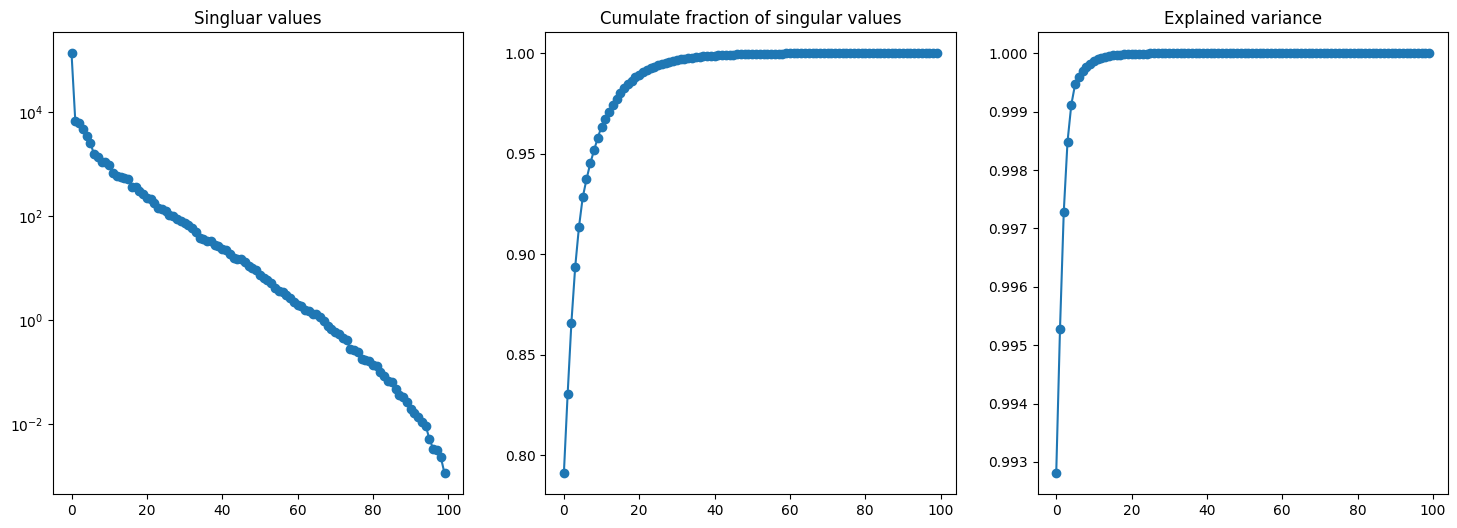

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (18,6))

axes[0].semilogy(s, 'o-')
axes[0].set_title('Singluar values')

axes[1].plot(np.cumsum(s)/np.sum(s), 'o-')
axes[1].set_title('Cumulate fraction of singular values')

axes[2].plot(np.cumsum(s**2)/np.sum(s**2), 'o-')
axes[2].set_title('Explained variance')

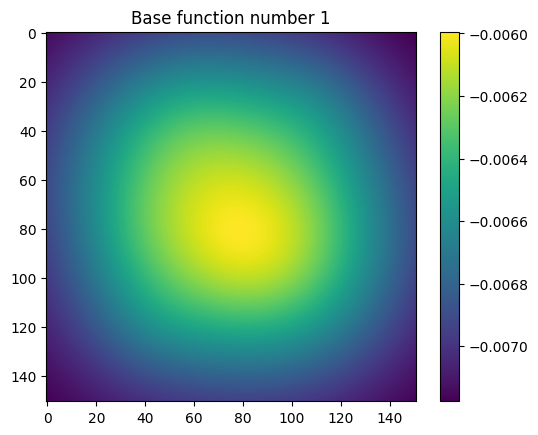

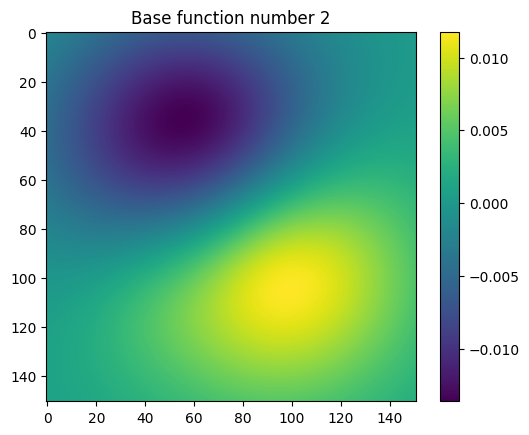

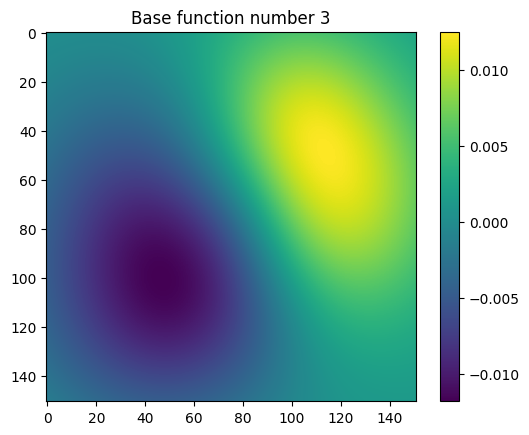

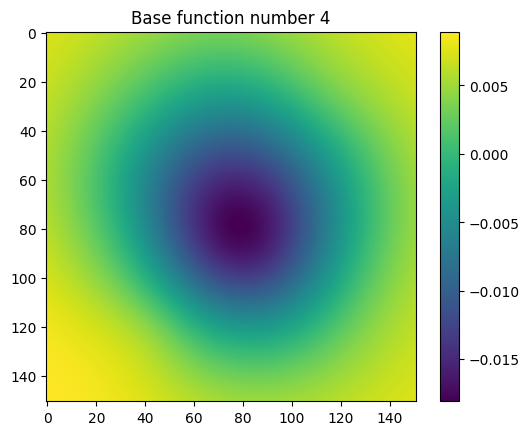

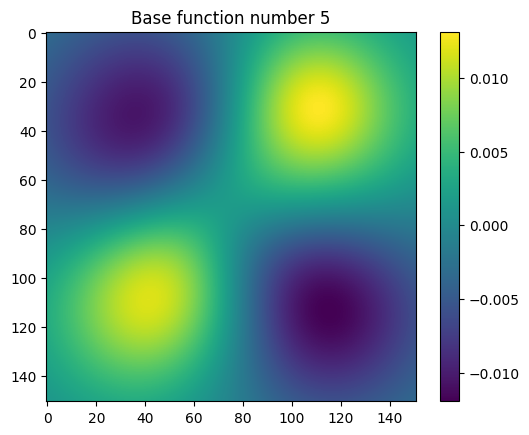

In [8]:
k = 5

for i in range(k):
  U_k = U[:, i].reshape(151, 151)
  plt.imshow(U_k)
  plt.title(f"Base function number {i+1}")
  plt.colorbar()
  plt.show()

In [9]:
p = 100
perm = np.random.choice(mesh_size, size=p, replace=False)

C = np.zeros((p,mesh_size))
for i in range(p):
    C[i,perm[i]] = 1.0

Theta = C @ U

In [10]:
coeff_mat = np.zeros((5, 100))

for i in range (100):
  u = A[:,i]
  y = C @ u
  s_c = cvx.Variable(U.shape[1])
  constraints = [Theta @ s_c == y]
  obj = cvx.Minimize(cvx.norm(s_c, 1))
  prob = cvx.Problem(obj, constraints)
  prob.solve()
  coeff_mat[:, i] = s_c.value[:5]
  print("coeff: ", s_c.value[:5])

coeff:  [-13196.28377595    929.7526688   -1416.1109964     212.83830749
   -668.50080321]
coeff:  [-13587.42822007   -669.31710481  -1151.54632132    264.44462356
    -64.21995489]
coeff:  [-1.36404555e+04 -5.40446706e+01  8.66785504e+02 -8.22558295e+00
 -2.95175470e+02]
coeff:  [-13604.96217723   -197.38216962  -1666.62125329   -233.41436659
   -577.40067319]
coeff:  [-14874.35704002   -100.12961563     83.21865515   -587.66545469
    -42.02503239]
coeff:  [-14017.74405204    889.17992022    141.9844622     272.82657759
    169.62291589]
coeff:  [-14510.47854999    735.3640305      91.85154074   -435.22600544
    343.9960104 ]
coeff:  [-13997.76398073   -814.13041662    -84.57093633   -124.28756753
    511.38075955]
coeff:  [-14396.70425845     93.15205525    114.40957827   -165.57321554
    212.38117009]
coeff:  [-13958.93239853   -589.82201307    999.53424018   -776.32182022
   -474.60261306]
coeff:  [-14649.37790304   -514.63807632   -273.5789223    -619.11968959
    497.52025938]

In [11]:
c1_min, c1_max = np.min(coeff_mat[0, :]), np.max(coeff_mat[0, :])
c2_min, c2_max = np.min(coeff_mat[1, :]), np.max(coeff_mat[1, :])
c3_min, c3_max = np.min(coeff_mat[2, :]), np.max(coeff_mat[2, :])
c4_min, c4_max = np.min(coeff_mat[3, :]), np.max(coeff_mat[3, :])
c5_min, c5_max = np.min(coeff_mat[4, :]), np.max(coeff_mat[4, :])

delta_c1 = c1_max - c1_min
delta_c2 = c2_max - c2_min
delta_c3 = c3_max - c3_min
delta_c4 = c4_max - c4_min
delta_c5 = c5_max - c5_min

print(f"c1 in ({c1_min}, {c1_max})")
print(f"c2 in ({c2_min}, {c2_max})")
print(f"c3 in ({c3_min}, {c3_max})")
print(f"c4 in ({c4_min}, {c4_max})")
print(f"c5 in ({c5_min}, {c5_max})")

c1 in (-14901.76139845606, -12144.02776578926)
c2 in (-1643.353299707074, 1582.2141690992414)
c3 in (-1666.621253291828, 1707.6147948942275)
c4 in (-776.3218202177171, 1280.58594495409)
c5 in (-1093.9742065145604, 1047.5995970184567)


Text(0.5, 1.0, 'Original')

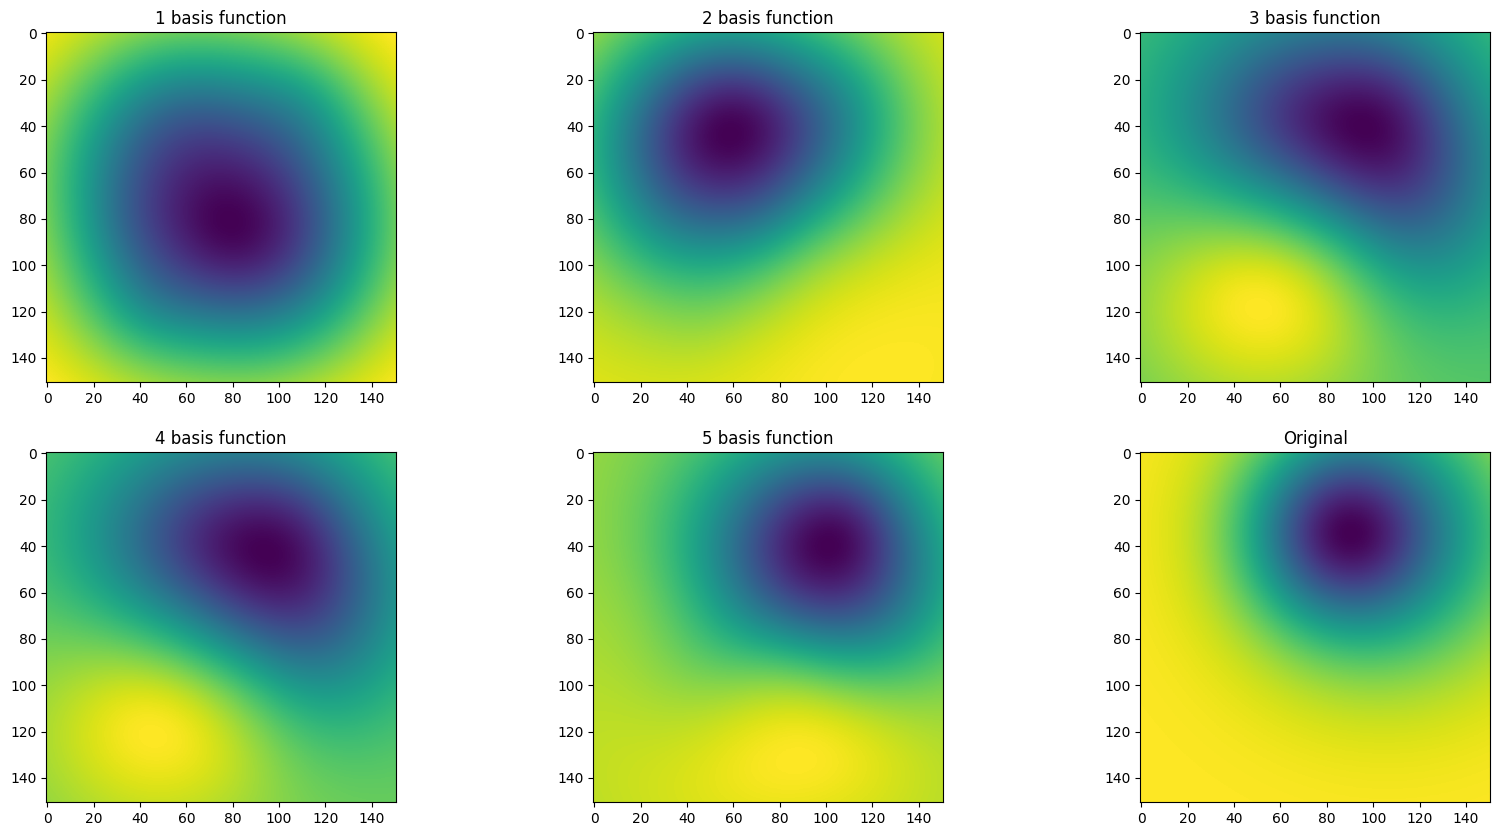

In [12]:
u = A[:,0]
y = C @ u
s_c = cvx.Variable(U.shape[1])
constraints = [Theta @ s_c == y]
obj = cvx.Minimize(cvx.norm(s_c, 1))
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.

fig,axs = plt.subplots(2,3, figsize = (20, 10))
axs = axs.flatten()

k = 5
n = 151

for i in range(k):
  bases = U[:, :(i+1)]
  coef = s_c.value[:(i+1)]

  urec = bases @ coef
  im1 = axs[i].imshow(np.reshape(urec,(n,n)))
  axs[i].set_title(f"{i+1} basis function")

im0 = axs[i+1].imshow(np.reshape(u, (n, n)))
axs[i+1].set_title('Original')

In [13]:
bases.shape

(22801, 5)

# PINN

In [14]:
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

!pip -q install pyDOE
from pyDOE import lhs

# set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

  Preparing metadata (setup.py) ... done


In [15]:
# collocation points
Ncl = 151**2
Xcl = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

In [32]:
# PINN loss function
def loss(xcl,ycl,xmeas,ymeas,umeas,coeff):
    input_data=tf.concat([xmeas,ymeas],1)
    umeas_pred = PINN(input_data)
    r_pred   = r_PINN(xcl,ycl,coeff)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.abs(r_pred))

    # bc
    y0 = tf.constant([-0.50784787],dtype=tf.float64)
    mse_bc= tf.pow( PINN( tf.transpose( tf.stack( [tf.constant([1.5],dtype=tf.float64), y0] ) ) ) ,2)

    return mse_meas + mse_r + mse_bc

# residual computation based on AD
@tf.function
def r_PINN(x,y,coeff):
    input_data=tf.concat([x,y],1)
    u = PINN(input_data)
    u_x = tf.gradients(u,x)[0]
    u_y = tf.gradients(u,y)[0]
    u_grad = tf.transpose(tf.concat([u_x, u_y], axis=1))

    pi = tf.constant(np.pi,dtype=tf.float64)
    theta_fiber = tf.constant([0.11629039] ,dtype=tf.float64)
    a_ratio = tf.constant([5.26792418], dtype=tf.float64)
    theta0 = pi/2 - theta_fiber

    a = tf.stack([tf.cos(theta0), tf.sin(theta0)])
    b = tf.stack([tf.cos(theta0-pi/2), tf.sin(theta0-pi/2)])

    D_00 = 1 / a_ratio * a[0]**2 + b[0]**2
    D_01 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_10 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_11 = 1 / a_ratio * a[1]**2 + b[1]**2

    c1 = c1_min + delta_c1 * coeff[0]
    c2 = c2_min + delta_c2 * coeff[1]
    c3 = c3_min + delta_c3 * coeff[2]
    c4 = c4_min + delta_c4 * coeff[3]
    c5 = c5_min + delta_c5 * coeff[4]

    coeff_true = tf.expand_dims(tf.concat([c1,c2,c3,c4,c5], 0), 1)

    return (bases@coeff_true)**2 * (((u_x * D_00 * u_x + u_x * D_01 * u_y + u_y * D_10 * u_x + u_y * D_11 * u_y)))  - 1


# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xmeas,ymeas,umeas,coeff):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xmeas,ymeas,umeas,coeff)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grads_weight= tape.gradient(loss_value,coeff)
    return loss_value, grads, grads_weight

In [33]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM

regularization_strength = 1e-3

PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,),
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    #tf.keras.layers.Reshape((1, 64)),

    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 64)),

    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(32, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation=None,
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64)
])

In [ ]:
#selected values  [0.10337211, 4.95760936, -0.50074575]  [0.12920869, 5.57823901, -0.51495002]
print((0.10337211+0.12920869)/2, ( 4.95760936+5.57823901)/2, (-0.50074575+-0.5149500)/2)

In [36]:
def checkpoint2_solution( x, y , t ):

  xmeas_train, xmeas_val, ymeas_train, ymeas_val, tmeas_train, tmeas_val = train_test_split(x, y, t, test_size=0.05)
  xmeas_train = tf.constant(xmeas_train.reshape(19, 1), dtype=tf.float64)
  ymeas_train = tf.constant(ymeas_train.reshape(19, 1), dtype=tf.float64)
  tmeas_train = tf.constant(tmeas_train.reshape(19, 1), dtype=tf.float64)
  xmeas_val = tf.constant(xmeas_val.reshape(1, 1), dtype=tf.float64)
  ymeas_val = tf.constant(ymeas_val.reshape(1, 1), dtype=tf.float64)
  tmeas_val = tf.constant(tmeas_val.reshape(1, 1), dtype=tf.float64)

  X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))

  coeff=tf.Variable([[0.5],[0.5],[0.5],[0.5],[0.5]], trainable=True, dtype=tf.float64)

  tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.99)

  """
  patience = float('inf')
  patience_lr= float('inf')
  min_delta = 1e-9
  best_val_loss = float('inf')
  wait = 0
  count = 0
  """

  print()
  for iter in range(4000):

    loss_value,grads,grads_coeff = grad(PINN,xcl,ycl,xmeas_train, ymeas_train, tmeas_train,coeff)

    tf_optimizer.apply_gradients(zip(grads + [grads_coeff],PINN.trainable_variables + [coeff]))

    loss_value_val, _, _ = grad(PINN, xcl, ycl, xmeas_val, ymeas_val, tmeas_val,coeff)

    """
    best_weigths = None
    best_params = None

    # Early stopping
    if loss_value_val < best_val_loss - min_delta:
        best_val_loss = loss_value_val
        wait = 0
        count = 0
        best_weights = PINN.get_weights()
        best_params = theta_fiber.numpy()
    else:
        wait += 1
        count += 1

        if count >= patience_lr:
          tf_optimizer.learning_rate = tf_optimizer.learning_rate * 0.9
          count = 0

        if wait >= patience:
            print('Early stopping at epoch', iter + 1)
            break
    """


    if ((iter+1) % 100 == 0):
      print('iter =  '+str(iter+1))
      tf.print('loss =' , loss_value)
      tf.print('loss_val_param =' , loss_value_val)

      c1 = c1_min + delta_c1 * coeff[0]
      c2 = c2_min + delta_c2 * coeff[1]
      c3 = c3_min + delta_c3 * coeff[2]
      c4 = c4_min + delta_c4 * coeff[3]
      c5 = c5_min + delta_c5 * coeff[4]

      coeff_true = tf.expand_dims(tf.concat([c1,c2,c3,c4,c5],0), 1)
      print(coeff_true.numpy())
      print()

  return coeff

In [37]:
weights = checkpoint2_solution(x_meas, y_meas , t_meas)


iter =  100
loss = [[0.2511235612747742]]
loss_val_param = [[0.32137530327159913]]
[[-1.27172019e+04]
 [-5.11314545e+00]
 [-9.29091291e+01]
 [-6.37521588e+02]
 [ 3.28214120e+01]]

iter =  200
loss = [[0.66495374343693325]]
loss_val_param = [[0.6958659651124306]]
[[-11969.52999508]
 [    14.09028911]
 [   -59.57455122]
 [  -662.24190986]
 [    51.68359614]]

iter =  300
loss = [[0.32971227074862869]]
loss_val_param = [[0.31079538640801335]]
[[-1.07981238e+04]
 [ 1.39053587e+00]
 [-6.82443266e+01]
 [-3.70985992e+02]
 [ 5.22419302e+01]]

iter =  400
loss = [[0.12705950072469954]]
loss_val_param = [[0.11920445641916122]]
[[-1.00545296e+04]
 [ 7.76290272e+00]
 [-5.69868865e+01]
 [-3.95176545e+02]
 [ 3.91901676e+01]]

iter =  500
loss = [[0.036349328121964175]]
loss_val_param = [[0.041824711865468808]]
[[-9.65269901e+03]
 [ 5.77991876e+00]
 [-5.39354624e+01]
 [-4.54544224e+02]
 [ 2.36499464e+01]]

iter =  600
loss = [[0.027029444171692694]]
loss_val_param = [[0.022601815982411469]]
[[-9.473

# signature of the function

def checkpoint3_solution( x, y , t ):

return speed_field



In [ ]:

def checkpoint3_solution( x, y , t ):

    speed_field = 0

    return speed_field

speed_field = checkpoint2_solution( x_meas, y_meas , t_meas )